In [3]:
import sqlite3 as sqlt
import pandas as pd
from datetime import datetime
import dateutil.relativedelta as oper_date
import io
import requests as req
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [4]:
querie = """select * from exports where "Cod. Mun" in {} and 
"NCM" like "6402%";"""
grendene_cidades = "(4307906, 4304804,  2312908, 2931350, 2304202, 2304400)"
alpargatas_cidades = "(2604007, 2504009, 3143302, 3530607)"


In [5]:
con = sqlt.connect("big_data2.db")
cursor = con.cursor()

In [135]:
def get_datetime(string):
    mes, ano = string.split("T")
    ano = "20" + ano
    dict_mes = {"1":3, "2":6, "3":9, "4":12}
    return datetime(int(ano), dict_mes[mes], 1)

def data_clean_db(dataframe):
    dict_nomes_colunas = {"month":"data","US$ de P1":"financeiro","Desc. Mun":"municipio",
                          "Kg Liq de P1":"peso","Qtd de P1":"quantidade"}
    dataframe.rename(columns=dict_nomes_colunas,inplace=True)
    dataframe.drop(axis=1,columns=['Cod. Mun', 'municipio', 'NCM', "Desc. NCM"],inplace=True)
    dataframe.data = dataframe.data.apply(
        lambda data: datetime.strptime(data.split()[0], "%Y-%m-%d"))
    dataframe.set_index("index", inplace=True)
    dataframe.financeiro = dataframe.financeiro.astype("int")
    dataframe.peso = dataframe.peso.astype("int") 
    
    return dataframe

def get_meses_por_trimestres(db):
    anos = list(range(2003,2018))
    trimestres = [3, 6, 9, 12]
    balanco_mensal = pd.DataFrame(columns=["1M","2M","3M","acumulado_meses","trimestre"])
    mes3 = (lambda exportacao: exportacao[2] if len(exportacao) == 3 else 0)
    for ano in anos:
        for trimestre in trimestres:
            trimestre_ = datetime(ano, trimestre, 1)
            tabela_trimestral = db[(db.data <= trimestre_) & 
                      (db.data > trimestre_ - oper_date.relativedelta(months=3))]
            tabela_trimestral = tabela_trimestral.groupby("data").quantidade.sum()
            balanco_mensal = balanco_mensal.append(
                    {"1M": tabela_trimestral[0],
                    "2M": tabela_trimestral[1],
                     "3M": mes3(tabela_trimestral),
                     "acumulado_meses": tabela_trimestral.sum(),
                     "trimestre": trimestre_ }, ignore_index=True)  
    balanco_mensal.set_index("trimestre",inplace=True)
    return balanco_mensal
    
    

In [136]:
grendene_db = pd.read_sql_query(querie.format(grendene_cidades), con)
alpargatas_db = pd.read_sql_query(querie.format(alpargatas_cidades), con)

grendene_db = data_clean_db(grendene_db)
alpargatas_db = data_clean_db(alpargatas_db)

In [171]:
balanco_mensal_gren = get_meses_por_trimestres(grendene_db)
balanco_mensal_alp = get_meses_por_trimestres(alpargatas_db)

In [172]:
balanco_trimestral_alp = pd.read_excel("Exportação calçados.xlsx")
balanco_trimestral_alp = balanco_trimestral_alp[
    ["Unnamed: 2","Volume exportado Alpargatas"]]
balanco_trimestral_alp.rename(columns={
    "Unnamed: 2":"trimestre","Volume exportado Alpargatas":"exportado"},inplace=True)
balanco_trimestral_alp.trimestre = balanco_trimestral_alp.trimestre.apply(
    lambda data:data.date())
balanco_trimestral_alp.dropna(inplace=True)
balanco_trimestral_alp.exportado = balanco_trimestral_alp.exportado.astype("int")
balanco_trimestral_alp.reset_index(inplace=True)  
balanco_trimestral_alp.drop(columns="index",inplace=True)

In [173]:
balanco_trimestral_alp.head(3)

,trimestre,exportado
0,2010-03-01,6500000
1,2010-06-01,7500000
2,2010-09-01,6100000


In [174]:
url = "http://ri.grendene.com.br/Arquivos/Grendene_Informacoes_Financeiras_Download.xls"
balanco_trimestral_gren = pd.read_excel(url, encoding="latin-1",sheet_name="Volumes")
balanco_trimestral_gren.head(5)

,Grendene S.A.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
NaN,Em milhares de pares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Volume de pares - Calçados,2006.0,1T07,2T07,1S07,3T07,9M07,4T07,2S07,2007.0,...,2016.0,1T17,2T17,1S17,3T17,9M17,4T17,2S17,2017.0,1T18
NaN,Mercado interno,100421.0,18501,18894,37395,30228,67623,37900,68128,105523.0,...,123595.0,26844,24133,50977,36448,87425,38950,75398,126375.0,29451
NaN,Exportação,31503.0,13152,6324,19476,7609,27085,12975,20584,40060.0,...,39962.0,11016,9228,20244,8733,28977,15994,24727,44971.0,10991


In [175]:
balanco_trimestral_gren.drop(columns="Grendene S.A.",inplace=True)
balanco_trimestral_gren = pd.DataFrame({"trimestre":balanco_trimestral_gren.iloc[2],
                                  "total_exportado":balanco_trimestral_gren.iloc[4]})
balanco_trimestral_gren.head(4)

,total_exportado,trimestre
Unnamed: 1,31503,2006
Unnamed: 2,13152,1T07
Unnamed: 3,6324,2T07
Unnamed: 4,19476,1S07


In [176]:
balanco_trimestral_gren.reset_index(inplace=True)
balanco_trimestral_gren.drop(axis=1,columns=["index"],inplace=True)
balanco_trimestral_gren.head(8)

,total_exportado,trimestre
0,31503,2006
1,13152,1T07
2,6324,2T07
3,19476,1S07
4,7609,3T07
5,27085,9M07
6,12975,4T07
7,20584,2S07


In [177]:
balanco_trimestral_gren = balanco_trimestral_gren[
                        balanco_trimestral_gren.trimestre.str[1] == "T"]
balanco_trimestral_gren.head(8)

,total_exportado,trimestre
1,13152,1T07
2,6324,2T07
4,7609,3T07
6,12975,4T07
9,18631,1T08
10,6786,2T08
12,9142,3T08
14,13285,4T08


In [178]:
balanco_trimestral_gren.trimestre = balanco_trimestral_gren.trimestre.apply(
    lambda string:get_trimestre(string))
balanco_trimestral_gren.head(4)

,total_exportado,trimestre
1,13152,2007-03-01
2,6324,2007-06-01
4,7609,2007-09-01
6,12975,2007-12-01


In [179]:
balanco_trimestral_gren.total_exportado = balanco_trimestral_gren.total_exportado.apply(
    lambda exportacao:exportacao*1000)
balanco_trimestral_gren.set_index("trimestre",inplace=True)
balanco_trimestral_gren.head(4)

,total_exportado
trimestre,
2007-03-01,13152000
2007-06-01,6324000
2007-09-01,7609000
2007-12-01,12975000


In [180]:
balanco_mensal_gren.info()
print("###########################################")
balanco_trimestral_gren.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2003-03-01 to 2017-12-01
Data columns (total 4 columns):
1M                 60 non-null object
2M                 60 non-null object
3M                 60 non-null object
acumulado_meses    60 non-null object
dtypes: object(4)
memory usage: 2.3+ KB
###########################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2007-03-01 to 2018-03-01
Data columns (total 1 columns):
total_exportado    45 non-null int64
dtypes: int64(1)
memory usage: 720.0 bytes


In [181]:
balanco_mensal_gren.head(5)

,1M,2M,3M,acumulado_meses
trimestre,,,,
2003-03-01,2917687,2990283,2452614,8360584
2003-06-01,2197177,1767084,661129,4625390
2003-09-01,1046892,1678653,0,2725545
2003-12-01,1970830,1059055,2594101,5623986
2004-03-01,3633704,3999037,3650149,11282890


In [182]:
balanco_mensal_gren = balanco_mensal_gren.iloc[16:]
balanco_mensal_gren.head(3)

,1M,2M,3M,acumulado_meses
trimestre,,,,
2007-03-01,3888139,5055361,3026261,11969761
2007-06-01,3128807,1553287,1835429,6517523
2007-09-01,2249176,3272847,2780883,8302906


In [183]:
balanco_trimestral_gren = balanco_trimestral_gren.iloc[:-1,]

In [185]:
balanco_mensal_gren.info()
print("###########################################")
balanco_trimestral_gren.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 4 columns):
1M                 44 non-null object
2M                 44 non-null object
3M                 44 non-null object
acumulado_meses    44 non-null object
dtypes: object(4)
memory usage: 1.7+ KB
###########################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 1 columns):
total_exportado    44 non-null int64
dtypes: int64(1)
memory usage: 704.0 bytes


In [188]:
relacao_mensal_trimestral_gren = balanco_mensal_gren
relacao_mensal_trimestral_gren["total_trimestre"] = balanco_trimestral_gren

In [190]:
relacao_mensal_trimestral_gren

,1M,2M,3M,acumulado_meses,total_trimestre
trimestre,,,,,
2007-03-01,3888139,5055361,3026261,11969761,13152000
2007-06-01,3128807,1553287,1835429,6517523,6324000
2007-09-01,2249176,3272847,2780883,8302906,7609000
2007-12-01,2444514,3174633,2863572,8482719,12975000
2008-03-01,8102110,6321099,4755067,19178276,18631000
2008-06-01,2850212,2004656,1890066,6744934,6786000
2008-09-01,2669581,3223286,4513222,10406089,9142000
2008-12-01,2770032,2386557,5822909,10979498,13285000
2009-03-01,5202739,6500850,4264563,15968152,15722000


In [199]:
balanco_mensal_alp.info()
print("##########################")
balanco_trimestral_alp.info()
balanco_mensal_alp = balanco_mensal_alp.iloc[28:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 4 columns):
1M                 32 non-null object
2M                 32 non-null object
3M                 32 non-null object
acumulado_meses    32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB
##########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
trimestre    32 non-null object
exportado    32 non-null int64
dtypes: int64(1), object(1)
memory usage: 592.0+ bytes


In [198]:
balanco_mensal_alp.info()
print("##########################")
balanco_trimestral_alp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 4 columns):
1M                 32 non-null object
2M                 32 non-null object
3M                 32 non-null object
acumulado_meses    32 non-null object
dtypes: object(4)
memory usage: 1.2+ KB
##########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
trimestre    32 non-null object
exportado    32 non-null int64
dtypes: int64(1), object(1)
memory usage: 592.0+ bytes


/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ValueError: color kwarg must have one color per dataset

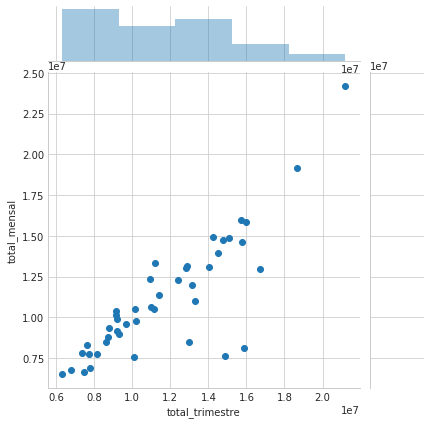

In [52]:
sns.jointplot(x="total_trimestre",
            y="total_mensal",data=relacao_mensal_trimestral_grend)

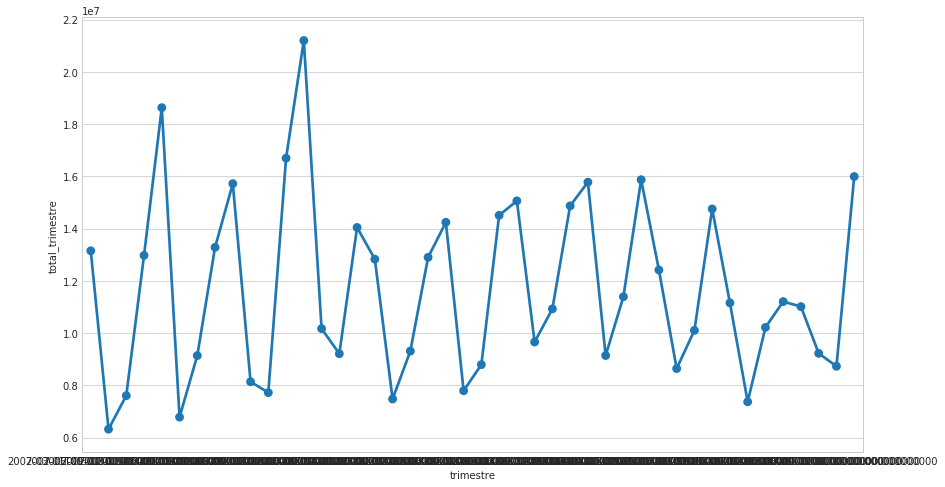

In [39]:
plt.figure(figsize=(14,8))
a = sns.pointplot(x=relacao_mensal_trimestral_grend.index, 
              y=relacao_mensal_trimestral_grend.total_trimestre)

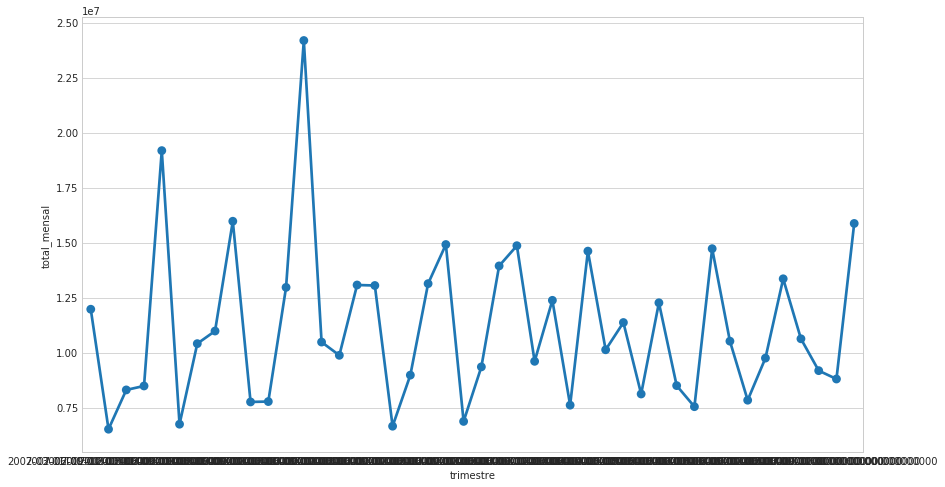

In [40]:
plt.figure(figsize=(14,8))
a = sns.pointplot(x=relacao_mensal_trimestral_grend.index, 
              y=relacao_mensal_trimestral_grend.total_mensal)

AxesSubplot(0.125,0.125;0.775x0.755)
